# Evaluación y analisis de lesiones de esclerosis múltiple en imágenes de resonancia magnética

Este cuaderno de Jupyter nos ayudara a entender y analizar las lesiones de esclerosis múltiple en imágenes de resonancia magnética.

In [2]:
import os
import random

### Configuración del entorno

In [3]:
os.chdir('..')

In [4]:
os.getcwd()

'/Users/castiler/TFM/nnUNet-em'

### Cargar librerías:

In [63]:
from scripts.A_config import NNUNetConfig, DatasetType
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt



## Analizando las imágenes de resonancia magnética

In [6]:
DATASET = DatasetType.TRAIN_SPLIT

In [8]:
train_images = os.listdir(NNUNetConfig().train_images_dir)
train_ids = sorted({file_name.split(".")[0][:-5] for file_name in train_images})

In [ ]:
def get_image_path(case_id, dataset=DATASET, basal_im=False, follow_up_im=False, labels=False, preds=False):
    """
    Obtiene el path de la imagen dado el ID del caso y el tipo de dataset.

    :param case_id: ID del caso
    :param dataset: Tipo de dataset (por defecto es DATASET)
    :param basal_im: Booleano para incluir imagen basal
    :param follow_up_im: Booleano para incluir imagen de seguimiento
    :param labels: Booleano para incluir etiquetas
    :param preds: Booleano para incluir predicciones
    :return: Path de la imagen
    """
    config = NNUNetConfig()
    termination = config.TERMINATION
    images_dir = config.train_images_dir if dataset == DatasetType.TRAIN_SPLIT else config.test_images_dir
    labels_dir = config.train_labels_dir if dataset == DatasetType.TRAIN_SPLIT else None
    predictions_dir = None

    paths = []
    if basal_im:
        paths.append(os.path.join(images_dir, f"{case_id}_0000{termination}"))
    if follow_up_im:
        paths.append(os.path.join(images_dir, f"{case_id}_0001{termination}"))
    if labels and labels_dir:
        paths.append(os.path.join(labels_dir, f"{case_id}{termination}"))
    if preds and predictions_dir:
        paths.append(os.path.join(predictions_dir, f"{case_id}{termination}"))

    if not paths:
        raise FileNotFoundError(f"No se encontró la imagen para el caso ID: {case_id}")

    return tuple(paths)

# Ejemplo de uso
case_id = "FIS_005_01"
image_path = get_image_path(case_id, DATASET, basal_im=True, follow_up_im=True, labels=True)
print(image_path)

('/Users/castiler/TFM/nnUNet-em/nnUNet_raw_data/Dataset001_NewLesions/imagesTr/FIS_005_01_0000.nii.gz', '/Users/castiler/TFM/nnUNet-em/nnUNet_raw_data/Dataset001_NewLesions/imagesTr/FIS_005_01_0001.nii.gz', '/Users/castiler/TFM/nnUNet-em/nnUNet_raw_data/Dataset001_NewLesions/labelsTr/FIS_005_01.nii.gz')


In [56]:
def read_image(case_id, dataset=DATASET):
    """
    Lee la imagen de un caso dado el ID del caso y el tipo de dataset.

    :param case_id: ID del caso
    :param dataset: Tipo de dataset (por defecto es DATASET)
    :return: Imagen
    """
    basal_image_path, follow_up_image_path = get_image_path(case_id, DATASET, basal_im=True, follow_up_im=True)
    basal_image = nib.load(basal_image_path).get_fdata()
    follow_up_image = nib.load(follow_up_image_path).get_fdata()
    return basal_image, follow_up_image

basal_image, follow_up_image = read_image(case_id, dataset=DATASET)

basal_image.shape, follow_up_image.shape




((182, 218, 182), (182, 218, 182))

In [44]:
def read_labels(case_id, dataset=DATASET):
    """
    Lee los labels de un caso dado el ID del caso y el tipo de dataset.

    :param case_id: ID del caso
    :param dataset: Tipo de dataset (por defecto es DATASET)
    :return: Labels
    """
    labels_path = get_image_path(case_id, dataset=dataset, labels=True)
    labels = nib.load(labels_path[0]).get_fdata()
    return labels

# Ejemplo de uso
labels = read_labels(case_id, dataset=DATASET)
print(labels.shape)

(182, 218, 182)


In [45]:
sample_b_image_path, sample_fu_image_path = get_image_path(case_id=case_id, dataset=DATASET,
                                                            basal_im=True, follow_up_im=True)
raw_sample_b_image = nib.load(sample_b_image_path)

In [46]:
print(raw_sample_b_image)


<class 'nibabel.nifti1.Nifti1Image'>
data shape (182, 218, 182)
affine:
[[  -1.    0.    0.   90.]
 [   0.    1.    0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 182 218 182   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  1.  1.  1.  0.  0.  0.  0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'6.0.5:9e026117'
aux_file        : b''
qform_code      : m

In [47]:
nib.aff2axcodes(raw_sample_b_image.affine)

('L', 'A', 'S')

[La orientación de los vóxeles es](https://github.com/eloydelas/lesion-segmentation-challenge-miccai21/blob/main/TFM_Implementacion.ipynb):

+ El primer eje va de derecha a izquierda (plano sagital);
+ El segundo eje va de detrás a adelante (plano coronal);
+ El tercer eje va de inferior a superior (plano axial).

In [48]:
IMAGES_SHAPE = raw_sample_b_image.shape

In [49]:
IMAGES_SHAPE

(182, 218, 182)

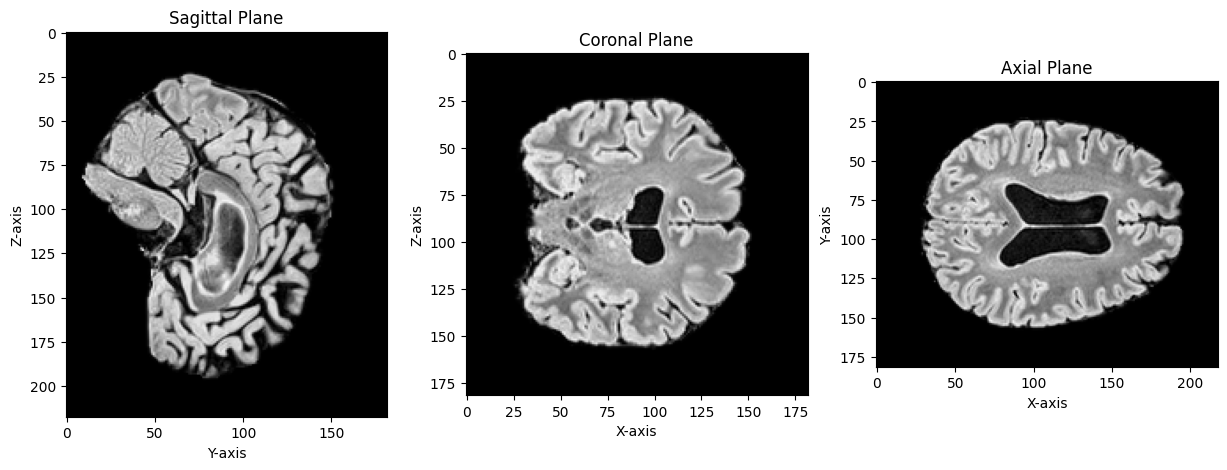

In [52]:
def plot_three_planes(image):
    """
    Plots the three planes (sagittal, coronal, axial) of the given image.

    :param image: Nibabel image object
    """
    data = image.get_fdata()
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Sagittal plane (x-axis)
    axes[0].imshow(data[data.shape[0] // 2, :, :], cmap='gray')
    axes[0].set_title('Sagittal Plane')
    axes[0].set_xlabel('Y-axis')
    axes[0].set_ylabel('Z-axis')

    # Coronal plane (y-axis)
    axes[1].imshow(data[:, data.shape[1] // 2, :], cmap='gray')
    axes[1].set_title('Coronal Plane')
    axes[1].set_xlabel('X-axis')
    axes[1].set_ylabel('Z-axis')

    # Axial plane (z-axis)
    axes[2].imshow(data[:, :, data.shape[2] // 2], cmap='gray')
    axes[2].set_title('Axial Plane')
    axes[2].set_xlabel('X-axis')
    axes[2].set_ylabel('Y-axis')

    plt.show()

# Ejemplo de uso
plot_three_planes(raw_sample_b_image)

### Visualizaciones de las imágenes y las máscaras:

In [54]:
ANALYSIS_DIR = NNUNetConfig().RAW_DATA_PATH / "Analysis"
try:
    os.mkdir(ANALYSIS_DIR)
except FileExistsError:
    pass

#### Lesiones basales

In [92]:
import random
import numpy as np

# Función corregida
def get_lesion_locations(labels, lesion_id=None):
    """
    Devuelve la localización de las lesiones en la matriz de etiquetas.

    :param labels: Matriz de etiquetas
    :param lesion_id: ID de la lesión a buscar
    :return: Lista de tuplas con las coordenadas de las lesiones
    """
    lesion_locations = []
    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            for k in range(labels.shape[2]):
                if labels[i, j, k] == lesion_id:
                    lesion_locations.append((i, j, k))
    return lesion_locations

# Ejemplo de uso
basal_lesion_locations = get_lesion_locations(labels, lesion_id=1)

# Asegurarse de que hay lesiones disponibles antes de continuar
if basal_lesion_locations:
    # Seleccionar aleatoriamente un voxel de las lesiones detectadas
    sample_basal_lesion_central_voxel = random.choice(basal_lesion_locations)

    # Calcular el centroide de las lesiones (coordenadas medias)
    sample_basal_lesion_centroid = tuple(
        np.mean(basal_lesion_locations, axis=0).astype(int)
    )

    # Imprimir resultados
    print("Voxel central de una lesión:", sample_basal_lesion_central_voxel)
    print("Centroide aproximado de las lesiones:", sample_basal_lesion_centroid)
else:
    print("No se encontraron lesiones con el ID especificado.")


Voxel central de una lesión: (111, 147, 93)
Centroide aproximado de las lesiones: (89, 106, 84)


In [95]:
from typing import Tuple, Union


def get_limits(central_voxel: Tuple[int], patch_size: int, im_shape: Tuple[int]):
    """Get the limits of the patch of size 'patch_size' around 'central_voxel' and within image limits."""
    # Initial limits:
    s_limits = [central_voxel[0] - patch_size, central_voxel[0] + patch_size]
    c_limits = [central_voxel[1] - patch_size, central_voxel[1] + patch_size]
    a_limits = [central_voxel[2] - patch_size, central_voxel[2] + patch_size]
    # Fitting them to the image size:
    for i, limits in enumerate([s_limits, c_limits, a_limits]):
        limits[0] = max(limits[0], 0)
        limits[1] = min(limits[1], im_shape[i])
    return s_limits, c_limits, a_limits

In [ ]:
def plot_lesion_planes(basal_image, follow_up_image, labels, lesion_voxel, zoom_size=20, apply_zoom=True):
    """
    Plots the three planes (sagittal, coronal, axial) of the given images and lesion with optional zoom.

    :param basal_image: Numpy array of the basal image
    :param follow_up_image: Numpy array of the follow-up image
    :param labels: Numpy array of the labels (binary: 0 or 1)
    :param lesion_voxel: Tuple with the coordinates of the lesion voxel
    :param zoom_size: Size of the zoomed area around the lesion voxel
    :param apply_zoom: Boolean to apply zoom or not
    """
    # Asegúrate de que la máscara sea binaria
    labels = np.where(labels > 0, 1, 0)

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    if apply_zoom:
        # Definir los límites de zoom
        x_min, x_max = max(0, lesion_voxel[0] - zoom_size), min(basal_image.shape[0], lesion_voxel[0] + zoom_size)
        y_min, y_max = max(0, lesion_voxel[1] - zoom_size), min(basal_image.shape[1], lesion_voxel[1] + zoom_size)
        z_min, z_max = max(0, lesion_voxel[2] - zoom_size), min(basal_image.shape[2], lesion_voxel[2] + zoom_size)
    else:
        # Usar toda la imagen
        x_min, x_max = 0, basal_image.shape[0]
        y_min, y_max = 0, basal_image.shape[1]
        z_min, z_max = 0, basal_image.shape[2]

    # Sagittal plane (x-axis)
    axes[0, 0].imshow(basal_image[lesion_voxel[0], y_min:y_max, z_min:z_max], cmap='gray')
    axes[0, 0].set_title('Basal Image - Sagittal Plane')
    axes[0, 0].set_xlabel('Y-axis')
    axes[0, 0].set_ylabel('Z-axis')

    axes[0, 1].imshow(follow_up_image[lesion_voxel[0], y_min:y_max, z_min:z_max], cmap='gray')
    axes[0, 1].set_title('Follow-up Image - Sagittal Plane')
    axes[0, 1].set_xlabel('Y-axis')
    axes[0, 1].set_ylabel('Z-axis')

    axes[0, 2].imshow(basal_image[lesion_voxel[0], y_min:y_max, z_min:z_max], cmap='gray')
    axes[0, 2].imshow(labels[lesion_voxel[0], y_min:y_max, z_min:z_max], cmap='autumn', alpha=0.3)  # Ajuste de transparencia y colormap
    axes[0, 2].set_title('Basal Image with Lesion - Sagittal Plane')
    axes[0, 2].set_xlabel('Y-axis')
    axes[0, 2].set_ylabel('Z-axis')

    # Coronal plane (y-axis)
    axes[1, 0].imshow(basal_image[x_min:x_max, lesion_voxel[1], z_min:z_max], cmap='gray')
    axes[1, 0].set_title('Basal Image - Coronal Plane')
    axes[1, 0].set_xlabel('X-axis')
    axes[1, 0].set_ylabel('Z-axis')

    axes[1, 1].imshow(follow_up_image[x_min:x_max, lesion_voxel[1], z_min:z_max], cmap='gray')
    axes[1, 1].set_title('Follow-up Image - Coronal Plane')
    axes[1, 1].set_xlabel('X-axis')
    axes[1, 1].set_ylabel('Z-axis')

    axes[1, 2].imshow(basal_image[x_min:x_max, lesion_voxel[1], z_min:z_max], cmap='gray')
    axes[1, 2].imshow(labels[x_min:x_max, lesion_voxel[1], z_min:z_max], cmap='autumn', alpha=0.3)  # Ajuste de transparencia y colormap
    axes[1, 2].set_title('Basal Image with Lesion - Coronal Plane')
    axes[1, 2].set_xlabel('X-axis')
    axes[1, 2].set_ylabel('Z-axis')

    # Axial plane (z-axis)
    axes[2, 0].imshow(basal_image[x_min:x_max, y_min:y_max, lesion_voxel[2]], cmap='gray')
    axes[2, 0].set_title('Basal Image - Axial Plane')
    axes[2, 0].set_xlabel('X-axis')
    axes[2, 0].set_ylabel('Y-axis')

    axes[2, 1].imshow(follow_up_image[x_min:x_max, y_min:y_max, lesion_voxel[2]], cmap='gray')
    axes[2, 1].set_title('Follow-up Image - Axial Plane')
    axes[2, 1].set_xlabel('X-axis')
    axes[2, 1].set_ylabel('Y-axis')

    axes[2, 2].imshow(basal_image[x_min:x_max, y_min:y_max, lesion_voxel[2]], cmap='gray')
    axes[2, 2].imshow(labels[x_min:x_max, y_min:y_max, lesion_voxel[2]], cmap='autumn', alpha=0.3)  # Ajuste de transparencia y colormap
    axes[2, 2].set_title('Basal Image with Lesion - Axial Plane')
    axes[2, 2].set_xlabel('X-axis')
    axes[2, 2].set_ylabel('Y-axis')

    plt.tight_layout()
    plt.show()

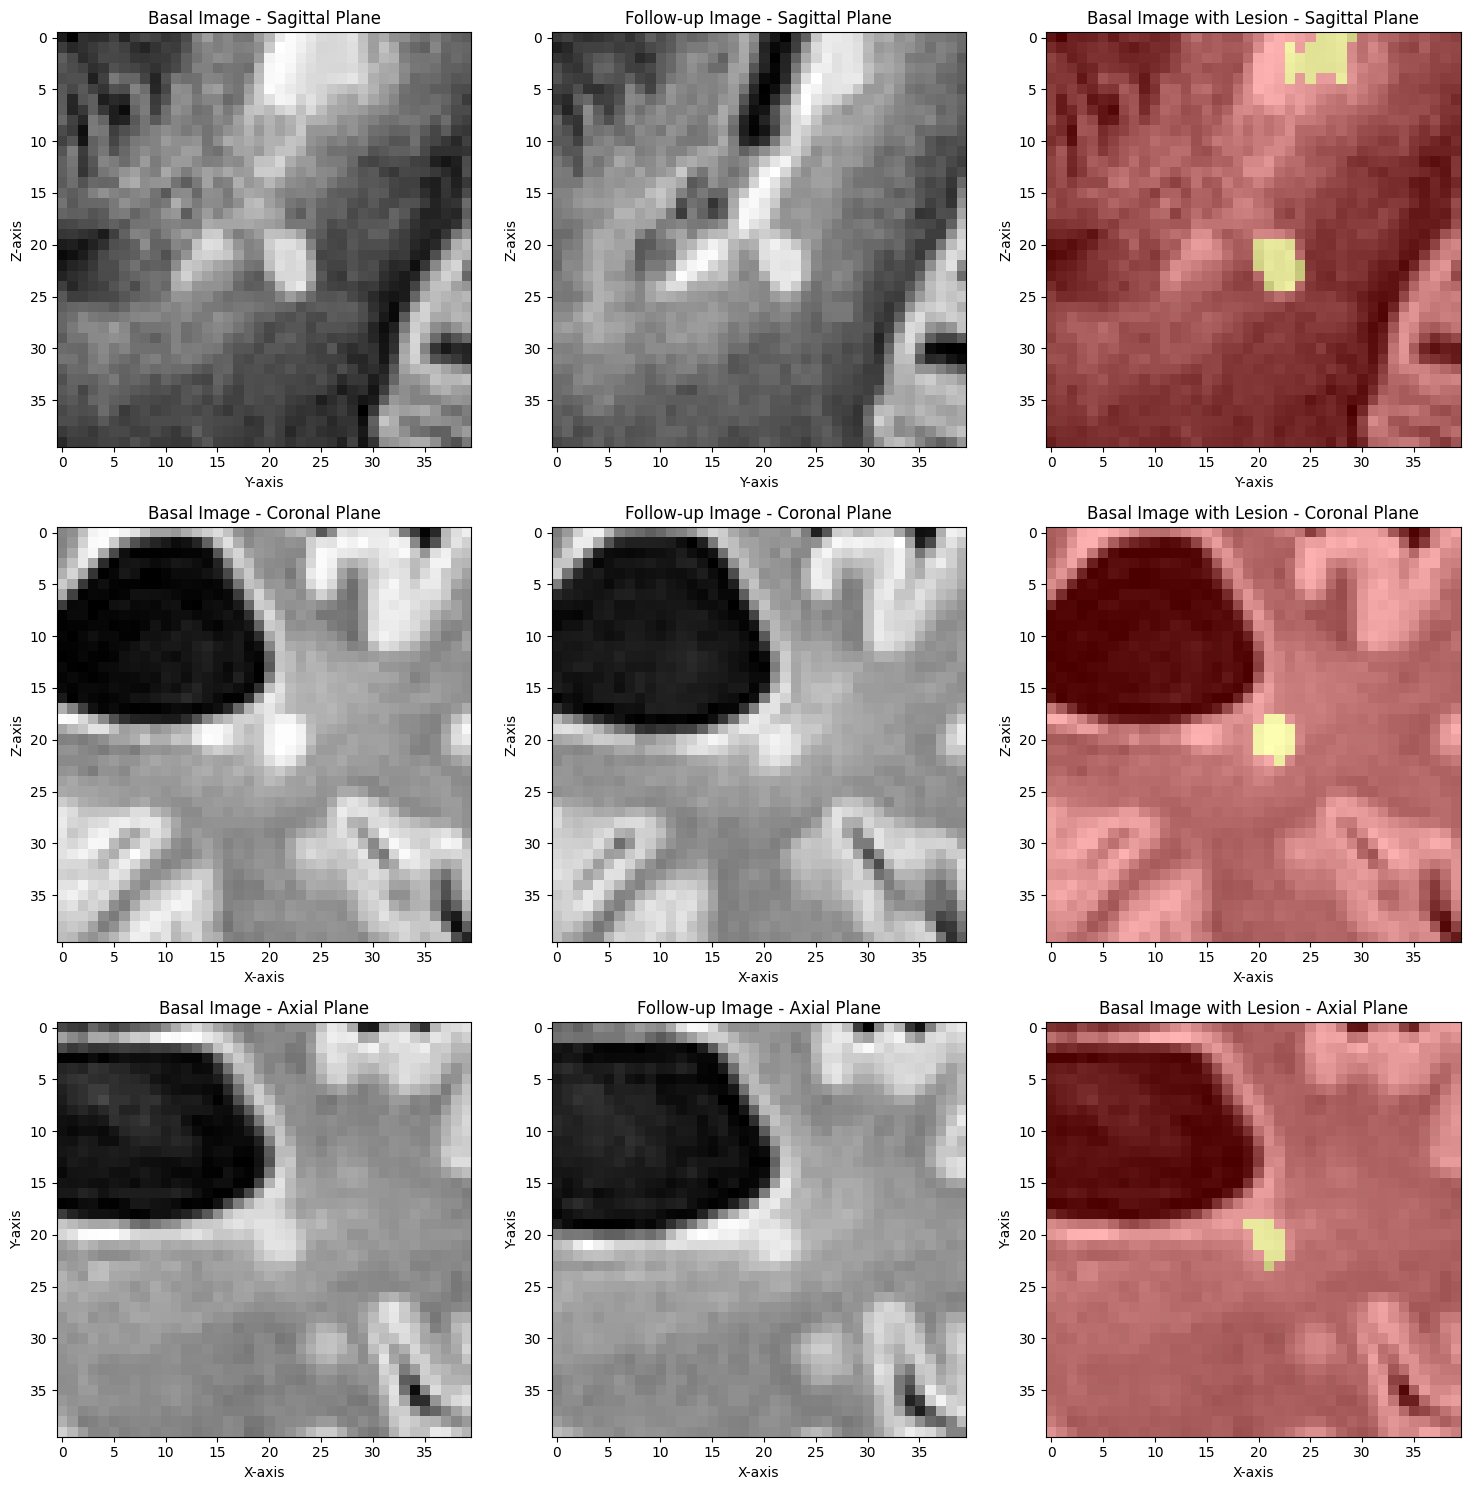

In [108]:
plot_lesion_planes(raw_sample_b_image.get_fdata(), nib.load(sample_fu_image_path).get_fdata(), labels, sample_basal_lesion_central_voxel)

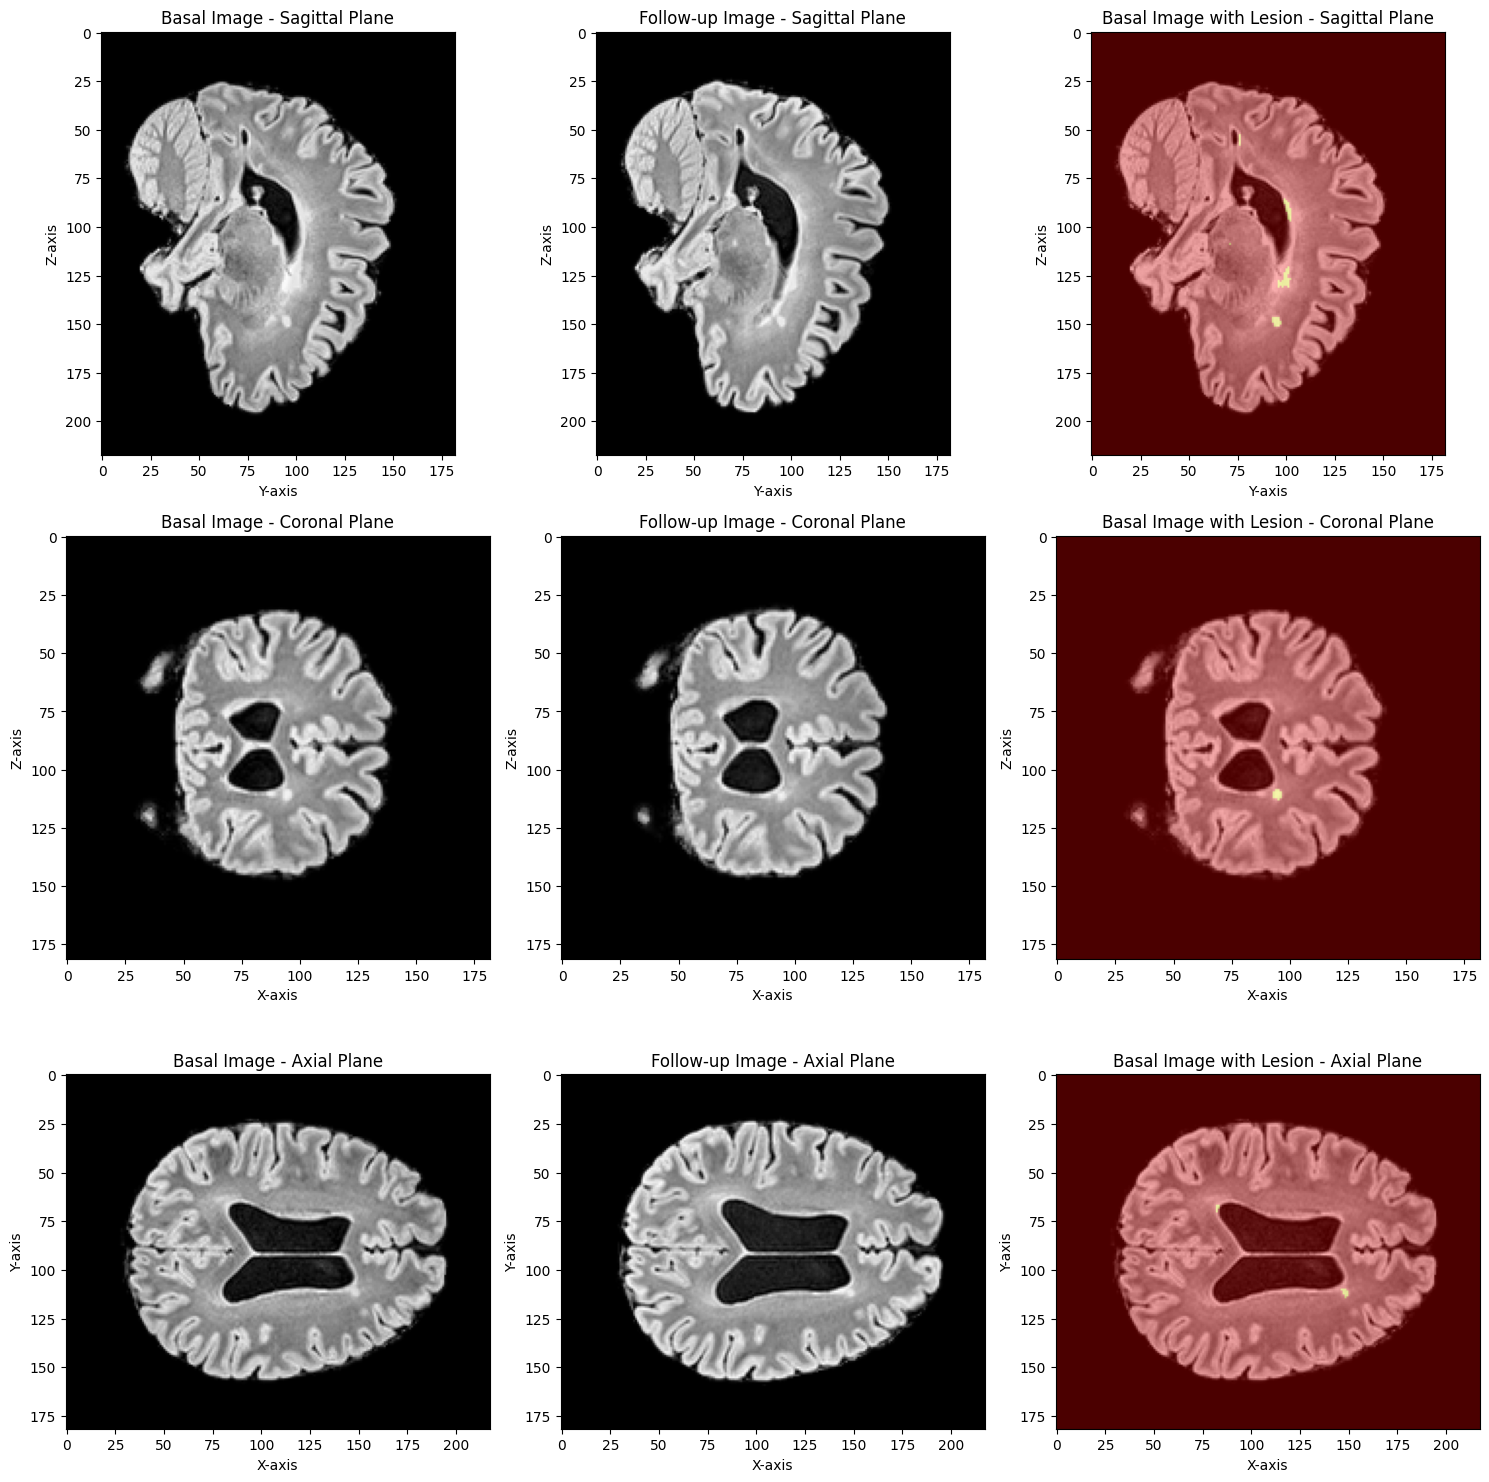

In [109]:
plot_lesion_planes(raw_sample_b_image.get_fdata(), nib.load(sample_fu_image_path).get_fdata(), labels, sample_basal_lesion_central_voxel, apply_zoom=False)


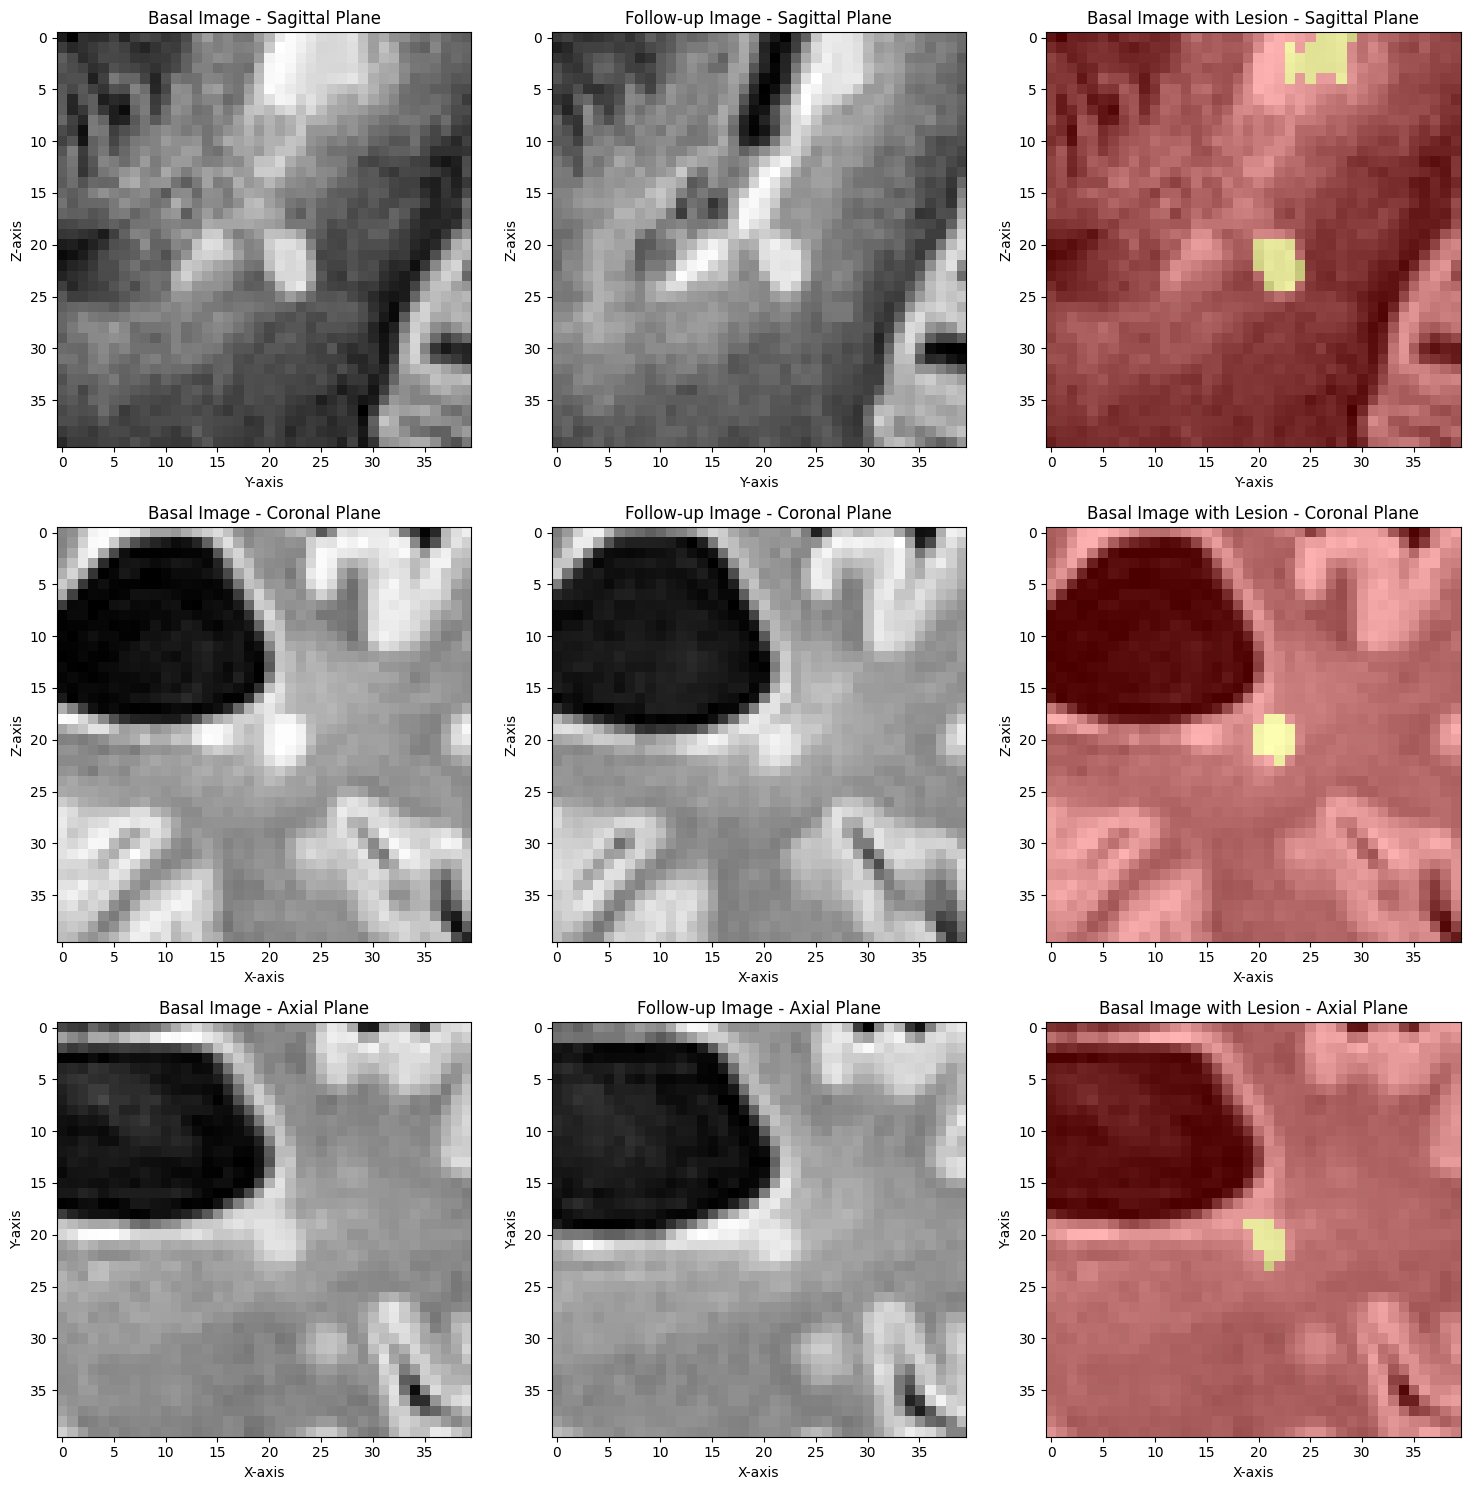

AttributeError: 'NoneType' object has no attribute 'savefig'

In [112]:
fig = plot_lesion_planes(raw_sample_b_image.get_fdata(), nib.load(sample_fu_image_path).get_fdata(), labels, sample_basal_lesion_central_voxel)

fig.savefig(ANALYSIS_DIR / f"{case_id}_lesion_planes.png")

## Lesiones nuevas